In [1]:
import os
from typing import Callable, Dict, List, Optional, Tuple, Type, Union
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.wrappers import FlattenObservation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.distributions import DictDistribution

import torch
from torch import nn
from torch.distributions import Categorical

NUM_FUNCTIONS = 3
MAX_INPUT = 10
MAX_STEPS = 6

class MyObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super(MyObservationWrapper, self).__init__(env)
        self.observation_space = spaces.MultiDiscrete([2 for _ in range(6)] + [MAX_INPUT for _ in range(6)])
            
    def reverse_observation(self, observation):
        return {
            "points": observation[:7],
            "features": observation[7:]
        }
    
    def observation(self, observation):
        return np.concatenate((observation["points"], observation["features"]), axis=0)
    
# class MyActionWrapper(gym.ActionWrapper):
#     def __init__(self, env):
#         super(MyActionWrapper, self).__init__(env)
        
#         fn_low = np.full((NUM_FUNCTIONS,), -10.0)
#         fn_high = np.full((NUM_FUNCTIONS,), 10.0)
        
#         inputs_low = np.full((1,), 0.0)
#         inputs_high = np.full((1,), MAX_INPUT)
        
#         self.action_space = spaces.Box(
#             low=np.concatenate((fn_low, inputs_low), axis=0), 
#             high=np.concatenate((fn_high, inputs_high), axis=0),
#             dtype=np.float32
#         )
        
#         latent_dim = NUM_FUNCTIONS
#         self.fn_net = nn.Linear(latent_dim, NUM_FUNCTIONS)
        
#     def action(self, action):
#         #print("action:", action)
#         #print("action.size()", len(action))
#         #print(self.fn_net.weight)
#         fn_logits = torch.tensor(action[:NUM_FUNCTIONS]) #self.fn_net(torch.tensor(action[:NUM_FUNCTIONS]))
#         #print("fn_logits:", fn_logits)
#         #fn_index = Categorical(logits=fn_logits).sample().item()
        
#         fn_index = torch.argmax(Categorical(logits=fn_logits).probs).item()
#         inputs = action[NUM_FUNCTIONS:]
        
#         #input_logits = torch.tensor(action[NUM_FUNCTIONS:])
#         #input_index = Categorical(logits=input_logits).sample().item()
        
#         res = {
#             "function": fn_index,
#             "input": round(inputs[0])
#         }
        
#         return res

#     def reverse_action(self, action):
#         fn_one_hot = np.zeros(NUM_FUNCTIONS)
#         fn_i = action["function"]
#         fn_one_hot[fn_i] = 1.0
        
#         inputs = np.array([action["input"],], dtype=np.float32)
#         #input_one_hot = np.zeros(MAX_INPUT)
#         #input_i = action["input"]
#         #input_one_hot[input_i] = 1.0
        
#         res = np.concatenate((fn_one_hot, inputs), axis=0)
#         return res
    
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


/Users/matus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from stable_baselines3.common.preprocessing import get_flattened_obs_dim
class MyFlattenExtractor(BaseFeaturesExtractor):
    """
    Feature extract that flatten the input.
    Used as a placeholder when feature extraction is not needed.

    :param observation_space:
    """

    def __init__(self, observation_space: gym.Space):
        super().__init__(observation_space, get_flattened_obs_dim(observation_space))
        self.flatten = nn.Flatten()

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.flatten(observations)
    
class CustomNetwork(nn.Module):
    """
    Custom network for policy and value function.
    It receives as input the features extracted by the feature extractor.

    :param feature_dim: dimension of the features extracted with the features_extractor (e.g. features from a CNN)
    :param last_layer_dim_pi: (int) number of units for the last layer of the policy network
    :param last_layer_dim_vf: (int) number of units for the last layer of the value network
    """

    def __init__(
        self,
        feature_dim: int,
        last_layer_dim_pi: int = 64,
        last_layer_dim_vf: int = 64,
    ):
        super(CustomNetwork, self).__init__()

        # IMPORTANT:
        # Save output dimensions, used to create the distributions
        self.latent_dim_pi = last_layer_dim_pi
        self.latent_dim_vf = last_layer_dim_vf

        # Policy network
        self.policy_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_pi), nn.ReLU(),
            nn.Linear(last_layer_dim_pi, last_layer_dim_pi), nn.ReLU()
        )
        # Value network
        self.value_net = nn.Sequential(
            nn.Linear(feature_dim, last_layer_dim_vf), nn.ReLU(),
            nn.Linear(last_layer_dim_vf, last_layer_dim_vf), nn.ReLU()
        )

    def forward(self, features: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :return: (th.Tensor, th.Tensor) latent_policy, latent_value of the specified network.
            If all layers are shared, then ``latent_policy == latent_value``
        """
        #print("features:", features)
        #print("features.size():", features.size())
        return self.policy_net(features), self.value_net(features)

    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        return self.policy_net(features)

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        return self.value_net(features)


class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        lr_schedule: Callable[[float], float],
        net_arch: Optional[List[Union[int, Dict[str, List[int]]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        *args,
        **kwargs,
    ):

        super(CustomActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            # Pass remaining arguments to base class
            *args,
            **kwargs,
        )
        # Disable orthogonal initialization
        self.ortho_init = False

    def _build_mlp_extractor(self) -> None:
        self.mlp_extractor = CustomNetwork(self.features_dim)

In [9]:
class DummyContract:
    def __init__(self, features):
        self.points = [0 for i in range(6)] #coverage
        self.features = features
        
    def fn0(self, x):
        if x <= self.features[0]:
            self.points[0] = 1
        
        if x >= self.features[1]:
            self.points[1] = 1
    
    def fn1(self, x):
        if x <= self.features[2]:
            self.points[2] = 1
        
        if x >= self.features[3]:
            self.points[3] = 1
    
    def fn2(self, x):
        if x <= self.features[4]:
            self.points[4] = 1
        
        if x >= self.features[5]:
            self.points[5] = 1

class MyEnv(gym.Env):
    
    def __init__(self):
        super(MyEnv, self).__init__()
        self.contract = None
        self.num_steps = None
        
        self.observation_space = spaces.Dict({
            "points": spaces.MultiBinary(6), 
            "features": spaces.MultiDiscrete([MAX_INPUT for _ in range(6)])
        })
        
        self.action_space = spaces.Dict({
            "function": spaces.Discrete(3), 
            "input":  spaces.Discrete(MAX_INPUT) #spaces.Box(low=0.0, high=MAX_INPUT, shape=(1,)) #spaces.Discrete(MAX_INPUT)
        })
        
    def reset(self):
        features = spaces.MultiDiscrete([MAX_INPUT for _ in range(6)]).sample().tolist()
        self.contract = DummyContract(features)
        self.num_steps = 0
        
        observation = {
            "points": np.array(self.contract.points, dtype=np.int8), 
            "features": np.array(self.contract.features)
        }
        return observation
    
    def step(self, action):
        self.num_steps += 1
        fn_index, fn_input = action["function"], action["input"]
        
        prev_score = sum(self.contract.points)

        if fn_index == 0:
            self.contract.fn0(fn_input)
        
        elif fn_index == 1:
            self.contract.fn1(fn_input)
            
        elif fn_index == 2:
            self.contract.fn2(fn_input)
            
        score = sum(self.contract.points)
        reward = score - prev_score
        
        reward = -1 if reward == 0 else reward
        
        info = {}
        
        done = self.num_steps == MAX_STEPS or score == 6
        
        #observation = np.array(self.contract.points).astype(np.int8)
        observation = {
            "points": np.array(self.contract.points, dtype=np.int8), 
            "features": np.array(self.contract.features)
        }

        return observation, reward, done, info
        
    def render(self, mode='console'):        
        raise NotImplementedError()

    def close(self):
        pass

env = MyEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [10]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = MyObservationWrapper(MyEnv())
env = Monitor(env, log_dir)

policy_kwargs = dict(
    #activation_fn=nn.ReLU
    features_extractor_class=MyFlattenExtractor,
    #features_extractor_kwargs=dict(features_dim=128),
)

#policy_kwargs = dict(net_arch=[64, 64])

#model = PPO(MlpPolicy, env, verbose=0, policy_kwargs=policy_kwargs)#, policy_kwargs=policy_kwargs)
model = PPO(CustomActorCriticPolicy, env, verbose=0, policy_kwargs=policy_kwargs)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=log_dir)

In [11]:
model.policy.mlp_extractor

CustomNetwork(
  (policy_net): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (value_net): Sequential(
    (0): Linear(in_features=72, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
)

In [12]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-3.69 +/- 1.65


In [14]:
model.learn(total_timesteps=100000, callback=callback)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

Num timesteps: 9760
Best mean reward: 2.20 - Last mean reward per episode: 3.22
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 19760
Best mean reward: 3.22 - Last mean reward per episode: 3.94
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 29760
Best mean reward: 3.94 - Last mean reward per episode: 4.06
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 39760
Best mean reward: 4.06 - Last mean reward per episode: 4.10
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 49760
Best mean reward: 4.10 - Last mean reward per episode: 4.48
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 59760
Best mean reward: 4.48 - Last mean reward per episode: 4.95
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 69760
Best mean reward: 4.95 - Last mean reward per episode: 5.25
Saving new best model to ./tmp/gym/best_model.zip
Num timesteps: 79760
Best mean reward: 5.25 - Last mean reward per episode: 5.42
Sav

In [15]:
# from pprint import pprint
# for i in range(100):
#     env = MyActionWrapper(MyObservationWrapper(MyEnv()))
#     obs = env.reset()
#     prints = []

#     for j in range(50):
#         action, _ = model.predict(obs)
#         obs, reward, done, info = env.step(action)
        
#         prints.append([action, obs, reward, done])
         
#         if done:
#             if j > 6:
#                 pprint(prints)
#             break

In [16]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1000)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:6.00 +/- 0.00


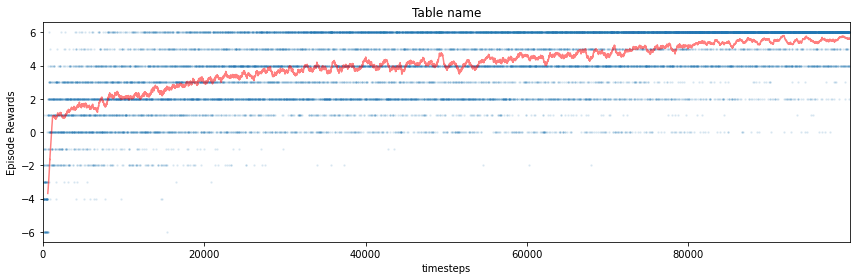

In [17]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "Table name", figsize=(12,4))

In [18]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=100)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

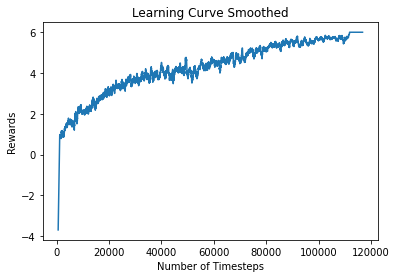

In [19]:
plot_results(log_dir)

In [25]:
torch.argmax(Categorical(logits=torch.tensor([0.5000, 0.5000, 1.0000])).probs).item()

2

In [41]:
env = MyActionWrapper(MyObservationWrapper(MyEnv()))
env.reset()

/Users/matus/venv/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


array([0, 0, 0, 0, 0, 0, 5, 2, 5, 3, 4, 9])

In [42]:
a = np.array([0.5, 0.5, 1.0, 5.3], dtype=np.float32)
env.action_space.contains(a)

True

In [43]:
env.action(a)

{'function': 2, 'input': 5}

In [44]:
ra = {'function': 2, 'input': 5}
env.reverse_action(ra)

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [45]:
a = np.array([1.0, -1.0, -0.5, 10.0], dtype=np.float32)
print(env.action(a))
env.step(a), env.num_steps

{'function': 0, 'input': 10}


((array([0, 1, 0, 0, 0, 0, 5, 2, 5, 3, 4, 9]), 1, False, {}), 1)

In [62]:
env.observation_space

MultiDiscrete([ 2  2  2  2  2  2 10 10 10 10 10 10])

In [63]:
env.action_space

Box([-10. -10. -10.   0.], [10. 10. 10. 10.], (4,), float32)

In [221]:
env.reverse_observation({
    'points': np.array([0, 0, 0, 0, 0, 0], dtype=np.int8),
    'features': np.array([3, 6, 2, 5, 7, 7])
})

reverse_observation


TypeError: unhashable type: 'slice'

In [38]:
spaces.MultiDiscrete([10 for _ in range(6)]).sample().tolist()

[7, 3, 8, 9, 9, 4]

In [12]:
b = spaces.Box(low=np.array([-np.inf,-np.inf, -np.inf, 0.0]), high=np.array([np.inf, np.inf, np.inf, 10.0]), dtype=np.float32) #low=-1.0, high=2.0, shape=(3, 4), dtype=np.float32)
b.sample()

array([-1.4797202 ,  0.32155442, -0.12585865,  1.9204402 ], dtype=float32)

In [15]:
a = np.zeros(3)
a[1] = 1.
a

array([0., 1., 0.])

In [1]:
from stable_baselines3.common.distributions import DictDistribution, DiagGaussianDistribution, CategoricalDistribution, MultiCategoricalDistribution
from gym import spaces
import torch

action_space = spaces.Dict({
    "function": spaces.Discrete(3), 
    "input":  spaces.Box(low=0.0, high=10.0, shape=(1,)) #spaces.Box(low=0.0, high=MAX_INPUT, shape=(1,)) #spaces.Discrete(10)
})
action_space

/Users/matus/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dict(function:Discrete(3), input:Box([0.], [10.], (1,), float32))

In [2]:
dd = DictDistribution(action_space)

In [8]:
dn, log_stds = dd.proba_distribution_net(64)

In [9]:
dn.modules

{'function': Linear(in_features=64, out_features=3, bias=True),
 'input': Linear(in_features=64, out_features=1, bias=True)}

In [11]:
t = dn(torch.rand(1,64))
t

tensor([[-0.0251, -0.3786, -0.2812, -0.0030]], grad_fn=<CatBackward0>)

In [12]:
dd.proba_distribution(torch.rand(1,4), log_stds, {"input": 1.0})

In [13]:
dd.proba_distributions

{'function': <stable_baselines3.common.distributions.CategoricalDistribution at 0x10598d820>,
 'input': <stable_baselines3.common.distributions.DiagGaussianDistribution at 0x10598db20>}

In [14]:
dd.proba_distributions["function"].log_prob(torch.tensor([2]))

tensor([-1.3400])

In [15]:
dd.proba_distributions["input"].log_prob(torch.tensor([0.6]))

tensor([-0.9959], grad_fn=<SumBackward1>)

In [16]:
list(dd.proba_distributions.values())

In [17]:
torch.stack([dist.sample().squeeze() for dist in dd.proba_distributions.values()], dim=-1)

tensor([0.0000, 3.4842], grad_fn=<StackBackward0>)

In [18]:
dd.proba_distributions["input"].mode()

tensor([[0.2077]])

In [19]:
dd.proba_distributions["function"].sample()

tensor([1])

In [20]:
dd.mode(), dd.sample()

({'function': tensor([0]), 'input': tensor([[0.2077]])},
 {'function': tensor([0]),
  'input': tensor([[-0.5962]], grad_fn=<AddBackward0>)})

In [21]:
 dd.actions_from_params(torch.rand(1,64), log_stds, {"input": 1.0})

tensor([1.0000, 1.4760], grad_fn=<StackBackward0>)

In [22]:
action = torch.tensor([[ 2.0000, -0.8836]])
torch.cat([dist.log_prob(action) for dist, action in zip(list(dd.proba_distributions.values()), torch.unbind(action, dim=1))])

tensor([-1.3197, -1.5673], grad_fn=<CatBackward0>)

In [23]:
dd.log_prob(torch.tensor([[ 2.0000, -0.8836]]))

{'function': tensor([-1.3197]),
 'input': tensor([-1.5673], grad_fn=<SumBackward1>)}

In [24]:
dd.log_prob_from_params(torch.rand(1,64), log_stds, {"input": 1.0})

IndexError: too many indices for tensor of dimension 1

In [35]:
dgd = DiagGaussianDistribution(1)

In [36]:
module, log_std = dgd.proba_distribution_net(64)

In [41]:
dgd.proba_distribution(torch.rand(1), log_std).log_prob(torch.tensor([0.6]))

tensor(-1.0351, grad_fn=<SumBackward0>)

In [65]:
cd = CategoricalDistribution(5)
module = cd.proba_distribution_net(64)
cd.proba_distribution(torch.rand(1,3))
cd.log_prob(torch.tensor([1]))
cd.entropy()
cd.sample()

tensor([1])

In [67]:
cd.actions_from_params(torch.rand(1,64), deterministic=True)

tensor([18])

In [49]:
action_space["function"].sample()

0

In [64]:
mcd = MultiCategoricalDistribution([10, 100])
module = mcd.proba_distribution_net(64)
mcd.proba_distribution(torch.rand(1,110))
#mcd.log_prob(torch.tensor([1]))
#mcd.sample()

In [78]:
tt = torch.rand(1,4)
tt

tensor([[0.5990, 0.2077, 0.2005, 0.4259]])

In [80]:
tt[:,2:3]

tensor([[0.2005]])

In [8]:
d = {"a": 0, "b": 1}
for i, k in enumerate(d):
    print(i, k)

0 a
1 b
